In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
import ipywidgets as widgets

In [ ]:
# Rule Functions
def conways_game_of_life(grid, x, y):
    neighbors = get_neighbors(grid, x, y)
    total_alive = np.sum(neighbors == 1)
    state = grid[x, y]
    if state == 1 and (total_alive < 2 or total_alive > 3):
        return 0
    elif state == 0 and total_alive == 3:
        return 1
    else:
        return state

def day_and_night(grid, x, y):
    neighbors = get_neighbors(grid, x, y)
    total_alive = np.sum(neighbors == 1)
    state = grid[x, y]
    if state == 0 and total_alive in [3, 6, 7, 8]:
        return 1
    elif state == 1 and total_alive in [3, 4, 6, 7, 8]:
        return 1
    else:
        return 0

def brians_brain(grid, x, y):
    state = grid[x, y]
    neighbors = get_neighbors(grid, x, y)
    total_alive = np.sum(neighbors == 1)
    if state == 2:  # Dying becomes dead
        return 0
    elif state == 1:  # Alive becomes dying
        return 2
    elif state == 0 and total_alive == 2:  # Dead with exactly two alive neighbors becomes alive
        return 1
    else:
        return state

def seeds(grid, x, y):
    neighbors = get_neighbors(grid, x, y)
    total_alive = np.sum(neighbors == 1)
    state = grid[x, y]
    return 1 if state == 0 and total_alive == 2 else 0


In [ ]:

# Helper function to get neighbors
def get_neighbors(grid, x, y):
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx != 0 or dy != 0:
                nx, ny = (x + dx) % grid.shape[0], (y + dy) % grid.shape[1]
                neighbors.append(grid[nx, ny])
    return np.array(neighbors)

# Parse Initial Configuration
def parse_initial_config(input_string, size):
    if input_string.strip() == '':
        return np.random.randint(2, size=size)
    lines = input_string.strip().split('\n')
    grid = np.zeros(size, dtype=int)
    for i, line in enumerate(lines):
        for j, char in enumerate(line.strip()):
            if i < size[0] and j < size[1]:  # Ensure within grid bounds
                grid[i, j] = 1 if char == '1' else 0
    return grid

# CellularAutomata Class
class CellularAutomata:
    def __init__(self, size, rule_func, initial_config_str):
        self.size = size
        self.rule_func = rule_func
        self.grid = parse_initial_config(initial_config_str, size)
        self.fig, self.ax = plt.subplots()

    def apply_rule(self):
        new_grid = np.zeros(self.size, dtype=int)
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                new_grid[i, j] = self.rule_func(self.grid, i, j)
        self.grid = new_grid

    def update_plot(self, frame):
        self.apply_rule()
        self.ax.clear()
        self.ax.imshow(self.grid, cmap='binary')
        return self.ax,

def create_animation(ca, interval=100):
    anim = FuncAnimation(ca.fig, ca.update_plot, frames=200, interval=interval, blit=False)
    return anim


Output()

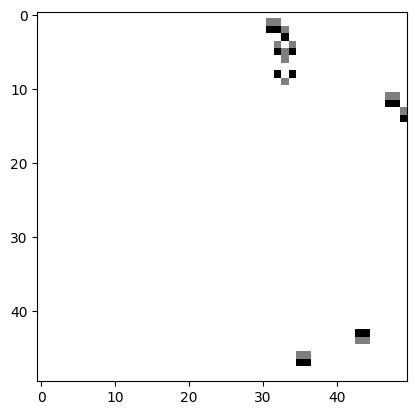

In [ ]:

# GUI Components
size_slider = widgets.IntSlider(value=50, min=10, max=100, step=1, description='Grid Size:')
rule_dropdown = widgets.Dropdown(options=["Conway's Game of Life", "Day and Night", "Brian's Brain", "Seeds"], description='Rule:')
interval_slider = widgets.IntSlider(value=100, min=10, max=1000, step=10, description='Interval:')
initial_config_input = widgets.Textarea(value='', placeholder='Enter grid configuration as rows of 0s and 1s, separated by newline...', description='Initial Config:', disabled=False, layout={'width': '400px', 'height': '100px'})
start_button = widgets.Button(description='Start')
output = widgets.Output()

rule_functions = {
    "Conway's Game of Life": conways_game_of_life,
    "Day and Night": day_and_night,
    "Brian's Brain": brians_brain,
    "Seeds": seeds
}

def start_animation(b):
    with output:
        output.clear_output(wait=True)
        size = (size_slider.value, size_slider.value)
        rule_func = rule_functions[rule_dropdown.value]
        initial_config_str = initial_config_input.value
        ca = CellularAutomata(size, rule_func, initial_config_str)
        anim = create_animation(ca, interval=interval_slider.value)
        display(HTML(anim.to_jshtml()))

start_button.on_click(start_animation)

# Display widgets and output
display(widgets.VBox([size_slider, rule_dropdown, interval_slider, initial_config_input, start_button]), output)


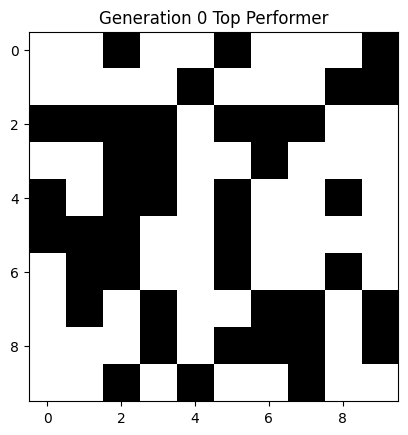

ValueError: invalid literal for int() with base 2: '-2-1-1-1-2-1-2-1-1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Parameters
grid_size = (10, 10)  # Size of the CA grid
k = 9  # Size of the Moore neighborhood (including center cell)
population_size = 20
num_generations = 10
mutation_rate = 0.01
top_r = 5  # Top R performers for crossover

# Target Shape
target_shape = np.zeros(grid_size, dtype=int)
target_shape[4:6, 4:6] = 1  # Simple target for demonstration

# Helper Functions
def get_neighbors(grid, x, y):
    neighbors = []
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            nx, ny = (x + dx) % grid.shape[0], (y + dy) % grid.shape[1]
            neighbors.append(grid[nx, ny])
    return np.array(neighbors)

def apply_rule(grid, rule):
    new_grid = np.zeros_like(grid)
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            neighborhood = get_neighbors(grid, x, y)
            index = int(''.join(map(str, neighborhood)), 2)
            new_grid[x, y] = rule[index]
    return new_grid

def fitness(final_state):
    return np.sum(final_state == target_shape)

# Crossover Functions
def crossover(parent1, parent2, method):
    if method == 'and':
        return parent1 & parent2
    elif method == 'or':
        return parent1 | parent2
    elif method == 'xor':
        return parent1 ^ parent2
    elif method == 'nand':
        return ~(parent1 & parent2)

# Mutation
def mutate(bitstring):
    for i in range(len(bitstring)):
        if random.random() < mutation_rate:
            bitstring[i] = 1 - bitstring[i]

# Initialize Population
population = [{'rule': np.random.randint(2, size=(2**k)),
               'config': np.random.randint(2, size=grid_size)} for _ in range(population_size)]

# Genetic Algorithm
for generation in range(num_generations):
    # Fitness Evaluation
    scores = []
    for individual in population:
        final_state = apply_rule(individual['config'], individual['rule'])
        scores.append(fitness(final_state))

    # Selection
    ranked = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    top_performers = [population[i] for i in ranked[:top_r]]

    # Display top performer of the generation
    top_final_state = apply_rule(top_performers[0]['config'], top_performers[0]['rule'])
    plt.imshow(top_final_state, cmap='binary')
    plt.title(f"Generation {generation} Top Performer")
    plt.show()

    # Crossover and Mutation to create new population
    new_population = []
    for _ in range(population_size):
        parent1, parent2 = random.sample(top_performers, 2)
        crossover_method = random.choice(['and', 'or', 'xor', 'nand'])
        new_rule = crossover(parent1['rule'], parent2['rule'], crossover_method)
        new_config = crossover(parent1['config'].flatten(), parent2['config'].flatten(), crossover_method).reshape(grid_size)
        mutate(new_rule)
        mutate(new_config.flatten())
        new_population.append({'rule': new_rule, 'config': new_config})

    population = new_population

# Final display: Target Shape
plt.imshow(target_shape, cmap='binary')
plt.title("Target Shape")
plt.show()
